In [ ]:
### Encoding model for iEEG
# Pedro Pinheiro-Chagas
# Adapted from Christopher Holdgraf's git repo: 
#(https://github.com/choldgraf/paper-encoding_decoding_electrophysiology)

In [114]:
#import mne
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd


### 1. The data
Task: MMR - calculation, memory verification and "rest" ('17+5=23', 'I ate fruit today'). <br />
Type of data: epoched and baseline corrected, all concatenated. <br />
Brain feature: Normalized HFB power.  <br />

Stimuli features:
0. Task, trial, time, block
1. Task
    - condition(calculation, memory, rest) 
    - type (active, passive)
2. Calculation specs
    - number_format (digit, word, dot)
    - operand_1
    - operand_2
    - operand_min
    - operand_max
    - operation (addition, subtraction, multiplication)
    - ls_sl
    - result 
    - cross_decade
    - presented_result
    - abs_deviant
    - number of digits
3. Memory specs
    - memory type (autobio, self-external, self-internal, fact)
4. Behavior
    - RT
    - Accuracy
    - RT_lock
    
The features were already selected and the encoding matrix was consctructed in Matlab and saved as csv.

#### Plot examplar encoding matrix:

(-0.5, 7816.5, 2741.5, -0.5)

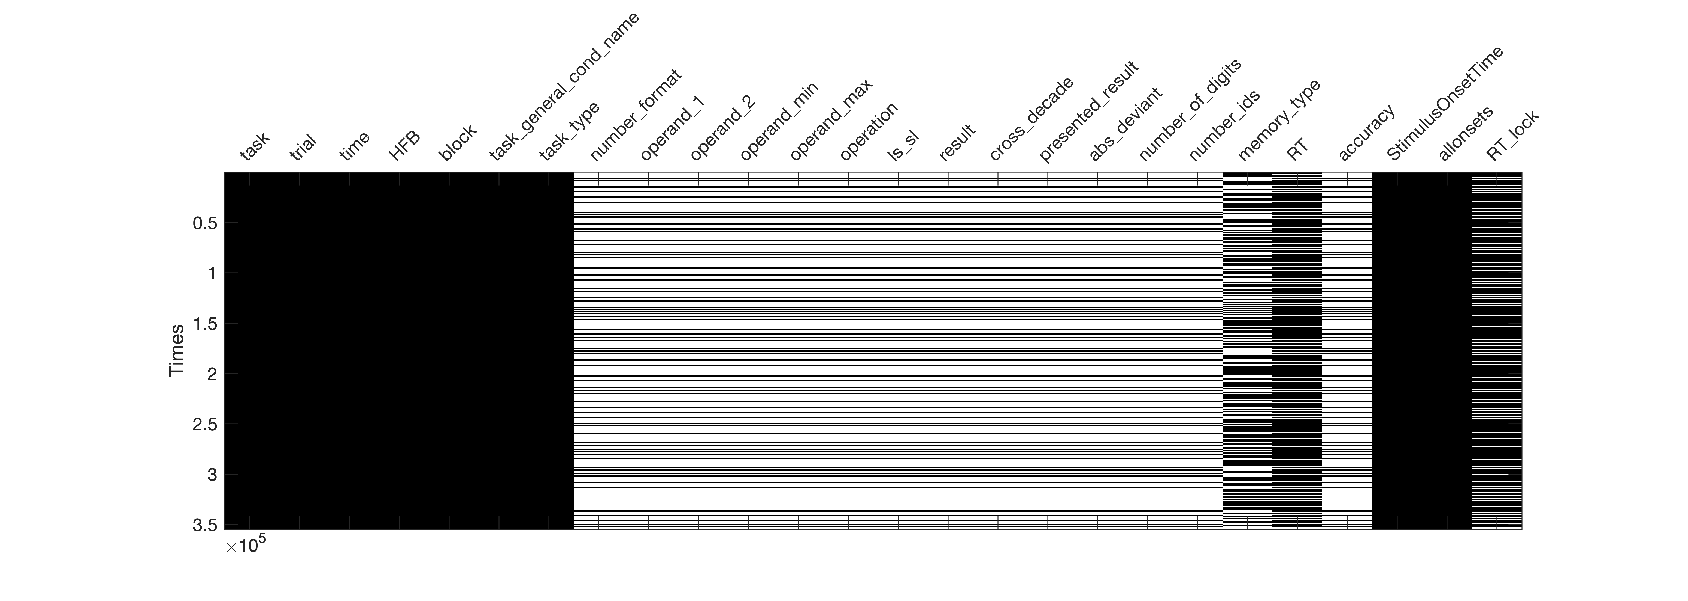

In [3]:
im = plt.imread('/Users/pinheirochagas/Pedro/Stanford/code/lbcn_encoding_decoding/figures/encoding_matrix.png') 
fig, ax = plt.subplots(figsize=(30, 15))
ax.imshow(im)
plt.axis('off')

### Load the data



In [103]:
data = np.genfromtxt('/Users/pinheirochagas/Pedro/Stanford/code/lbcn_encoding_decoding/data/data.csv', delimiter=',')

### Plot all blocks concatenated

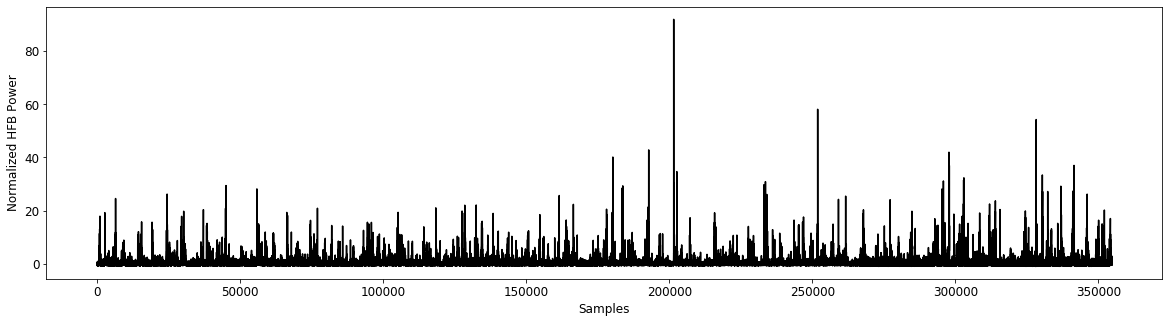

In [109]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(data[:,3], color='k')
plt.xlabel('Samples')
plt.ylabel('Normalized HFB Power')
plt.rcParams.update({'font.size': 20})

### Plot blocks saparated

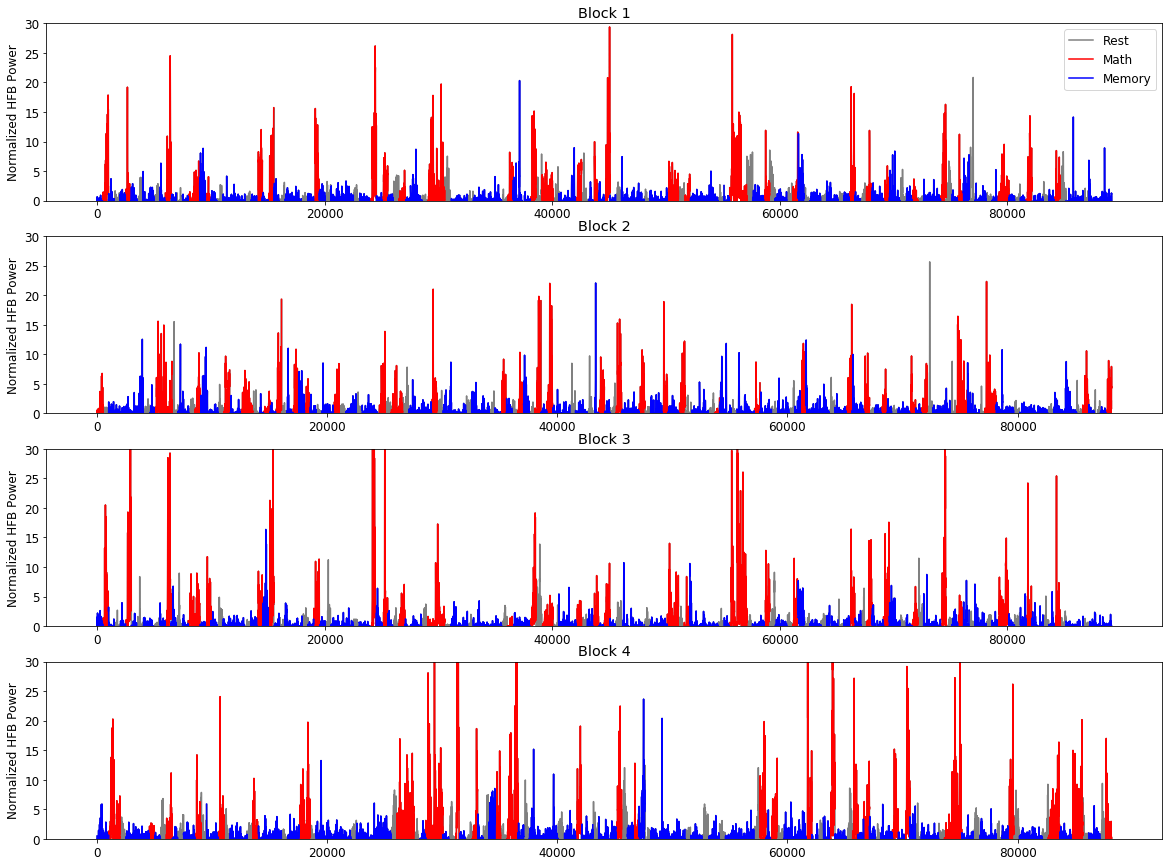

In [128]:
n_blocks = np.int(np.max(data[:,4]))
fig, ax = plt.subplots(n_blocks,1,figsize=(20, 15))

# Filter trials
math_trials = np.copy(data[:,3])
math_trials[data[:,5]!=4] = np.nan
memo_trials = np.copy(data[:,3])
memo_trials[data[:,5]!=6] = np.nan

for i in range(n_blocks):
    #ax[i].plot(samples[data[:,4]==i+1], data[data[:,4]==i+1,3])
    ax[i].plot(data[data[:,4]==i+1,3], color=[0.5,0.5,0.5], label="Rest")
    ax[i].plot(math_trials[data[:,4]==i+1], 'r', label="Math")
    ax[i].plot(memo_trials[data[:,4]==i+1], 'b', label="Memory")
    ax[i].set_ylim([0,30])
    ax[i].set_title('Block ' + str(i+1))
    #ax[i].set_xlabel('Samples')
    ax[i].set_ylabel('Normalized HFB Power')
    plt.rcParams.update({'font.size': 12}) 
    ax[0].legend()


In [51]:
np.shape(a)

(354708,)

In [35]:
np.unique(data[:,4])-1

array([0., 1., 2., 3.])

(0, 20)

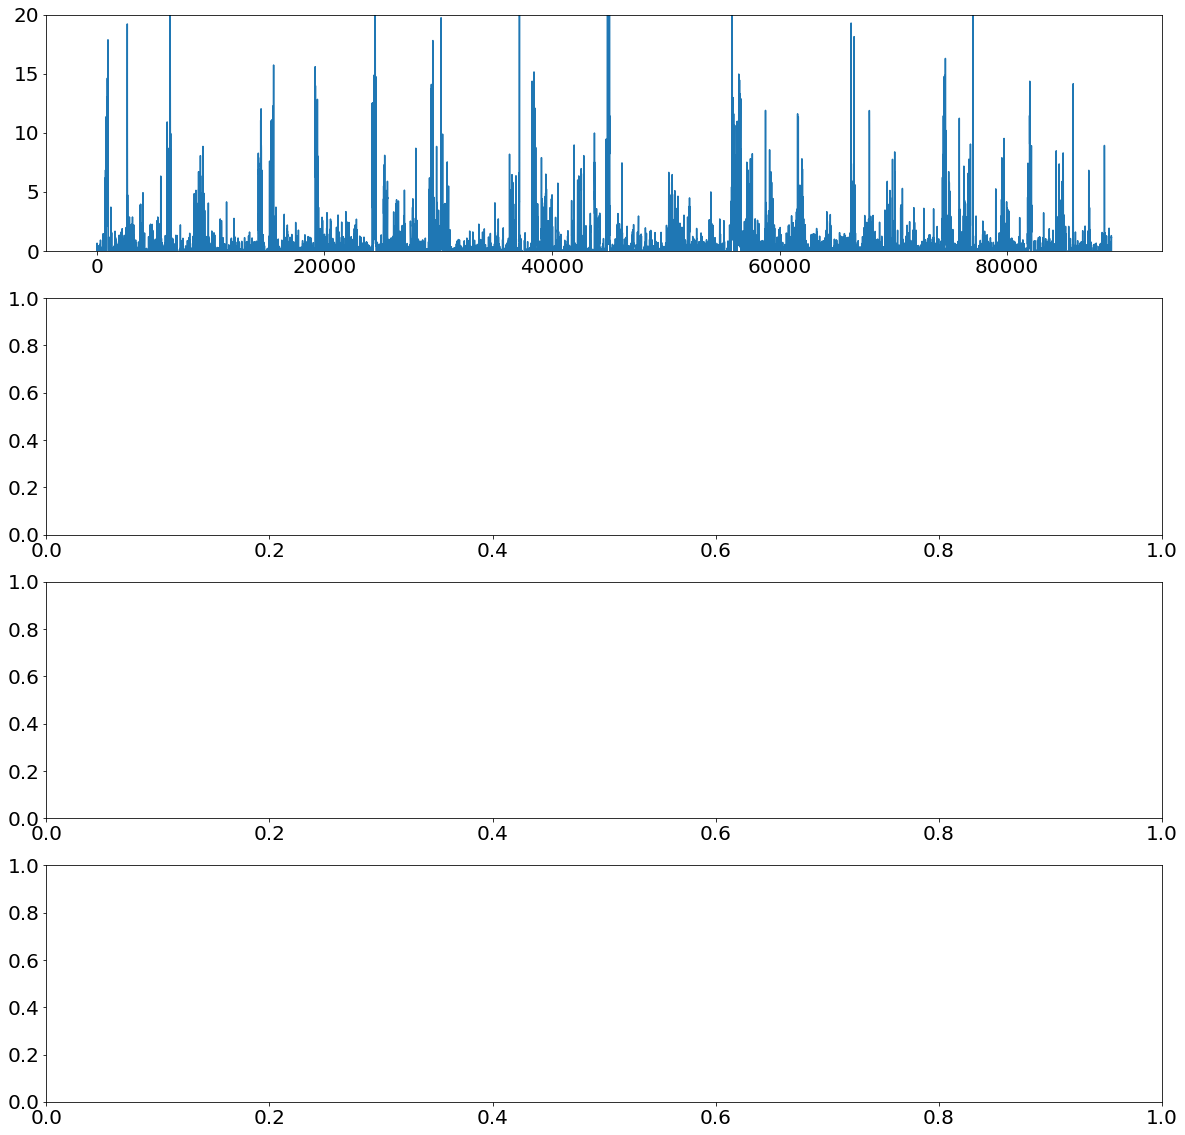

In [50]:
fig, ax = plt.subplots(n_blocks,1,figsize=(20, 20))

ax[0].plot(data[data[:,4]==1,3])
ax[0].set_ylim([0,20])

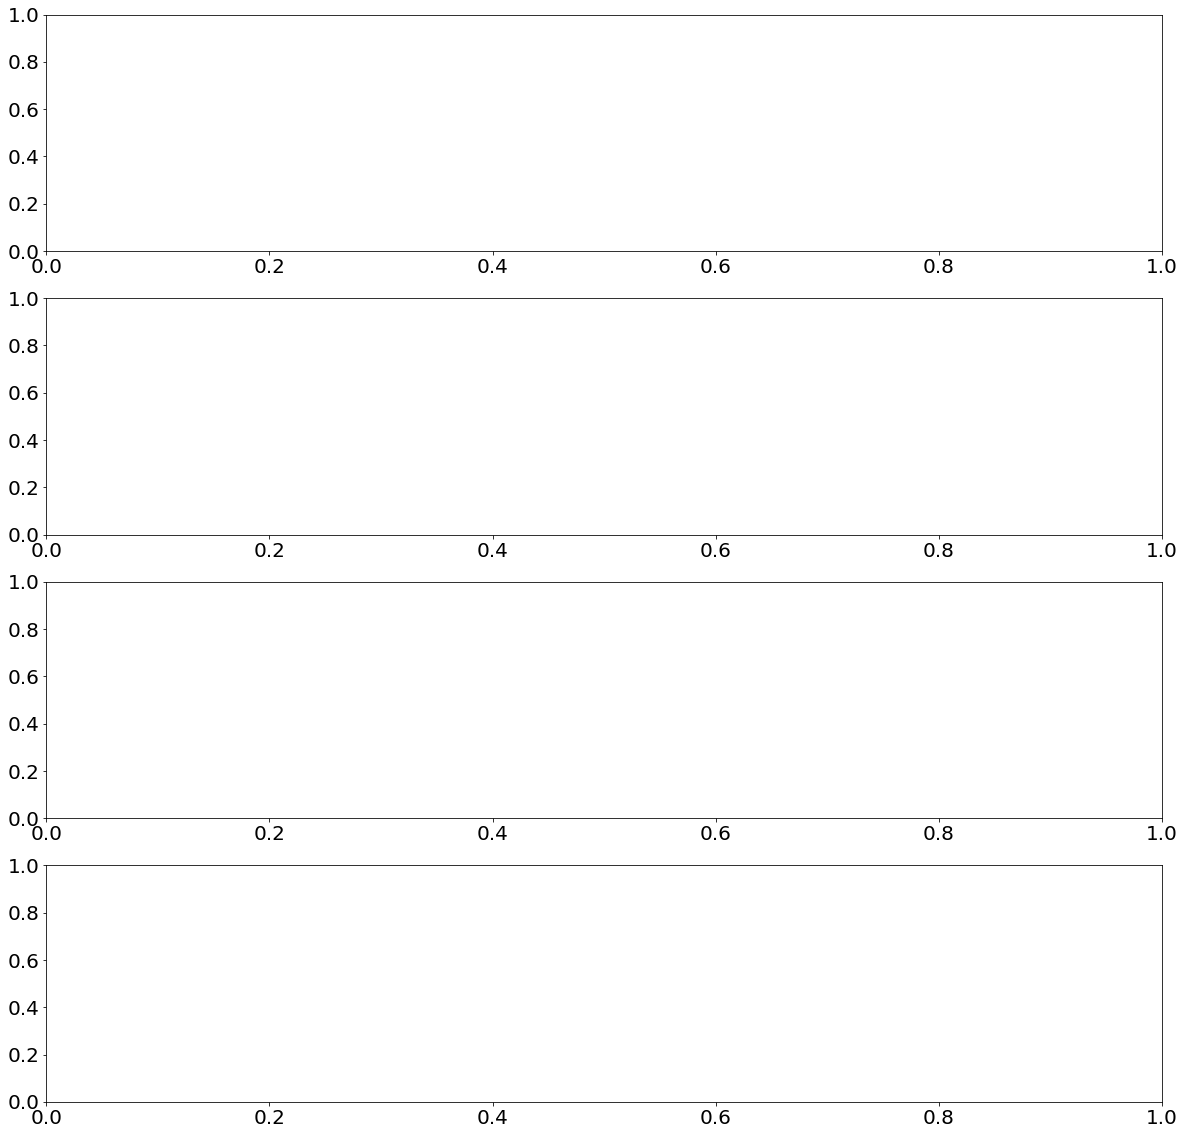

In [52]:
fig, ax = plt.subplots(n_blocks,1,figsize=(20, 20))



In [54]:
ax[0].set_ylabel

<bound method Axes.set_ylabel of <matplotlib.axes._subplots.AxesSubplot object at 0x125ae7e80>>